In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing
import time
import itertools
from sklearn.cluster import KMeans
from scipy import stats
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

In [3]:
industry_df = pd.read_csv('Data/movie_industry.csv', encoding='latin-1')
oscar_df = pd.read_csv('Data/the_oscar_award.csv', encoding='latin-1')
links_df = pd.read_csv('Data/movie_lense/links.csv')
tags_df = pd.read_csv('Data/movie_lense/tags.csv')
genome_scores_df = pd.read_csv('Data/movie_lense/genome-scores.csv')
movies_df = pd.read_csv('Data/movie_lense/movies.csv')
ratings_df = pd.read_csv('Data/movie_lense/ratings.csv')
genome_tags_df = pd.read_csv('Data/movie_lense/genome-tags.csv')

In [4]:
ratings_df
userID=5
def extract_user_movies(userID,thresh=4):
    tdf = ratings_df[ratings_df['userId']==userID]
    tdf = tdf[tdf['rating']>=thresh]
    return tdf['movieId'].values

extract_user_movies(5)

array([   47,    50,   296,   318,   527,   778,   858,  1147,  1193,
        1213,  1222,  1617,  1732,  2329,  2502,  2858,  2959,  3178,
        3949,  4011,  4226,  4973,  5110,  5137,  5954,  5995,  6016,
        7361,  8784,  8873,  8949,  8950, 27831, 30749, 30820, 31410,
       32587, 33794, 38061, 40278, 44195, 44204, 46976, 48394, 48516,
       48696, 48774, 48780, 49272, 49530, 50068, 51255, 52952, 54286,
       54503, 54997, 55118, 55247, 55290, 55765, 55820, 56367, 56782],
      dtype=int64)

In [5]:
tgsdf = genome_scores_df.pivot(index='movieId',columns='tagId',values='relevance')
genome_tags_dict = dict(zip(genome_tags_df['tagId'],genome_tags_df['tag']))
movie_names_dict = dict(zip(movies_df['movieId'],movies_df['title']))
tags = genome_tags_df['tag'].values
# genome_tags_dict
# movie_names_dict
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [6]:
movie_tags_df = tgsdf.rename(genome_tags_dict,axis='columns')
movie_tags_thresh_df = movie_tags_df.copy()
thresh = 0.8
movie_tags_thresh_df[movie_tags_thresh_df<thresh] = 0
movie_tags_thresh_df[movie_tags_thresh_df>thresh] = 1
# movie_tags_df.sum()
movie_tags_df

tagId,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0.05650,0.23175,0.04575,0.05175,0.44700,0.19875,0.04025,...,0.34725,0.03125,0.03500,0.12125,0.32200,0.08200,0.03325,0.02425,0.13725,0.02625
185585,0.04250,0.04175,0.06475,0.07625,0.08500,0.03800,0.03425,0.16850,0.02525,0.03525,...,0.04325,0.05850,0.03050,0.02750,0.21850,0.04525,0.03550,0.02550,0.17475,0.03100
186587,0.08950,0.09125,0.05075,0.04900,0.19475,0.04500,0.03125,0.17275,0.07850,0.02475,...,0.06475,0.04500,0.04000,0.01975,0.22075,0.15125,0.06150,0.04300,0.20800,0.03925


In [7]:
# Make matrix of euclidian distance b/w each movie
dist = euclidean_distances(movie_tags_df,movie_tags_df)

In [66]:
movie_tags_df.index.get_loc(1)

0

In [8]:
np.fill_diagonal(dist,np.median(dist)) # Make all diags median so they doont influence min or max
dist

array([[5.80485434, 5.60443644, 6.33694617, ..., 6.67146577, 6.76831775,
        5.63426966],
       [5.60443644, 5.80485434, 4.9950365 , ..., 5.46353316, 7.32374549,
        5.24566639],
       [6.33694617, 4.9950365 , 5.80485434, ..., 5.31612765, 6.81545049,
        5.03226821],
       ...,
       [6.67146577, 5.46353316, 5.31612765, ..., 5.80485434, 6.3338389 ,
        5.2941725 ],
       [6.76831775, 7.32374549, 6.81545049, ..., 6.3338389 , 5.80485434,
        5.05494847],
       [5.63426966, 5.24566639, 5.03226821, ..., 5.2941725 , 5.05494847,
        5.80485434]])

In [9]:
x, y = np.unravel_index(dist.argmin(), dist.shape)

In [10]:
print(movies_df[movies_df['movieId']==movie_tags_df.index[x]])
print(movies_df[movies_df['movieId']==movie_tags_df.index[y]])

       movieId         title                 genres
13173    63436  Saw V (2008)  Crime|Horror|Thriller
       movieId          title                         genres
14456    72129  Saw VI (2009)  Crime|Horror|Mystery|Thriller


In [11]:
dist.min()

1.1689048827856068

In [12]:
x, y = np.unravel_index(dist.argmax(), dist.shape)
print(movies_df[movies_df['movieId']==movie_tags_df.index[x]])
print(movies_df[movies_df['movieId']==movie_tags_df.index[y]])

       movieId                        title       genres
21078   102062  Band Called Death, A (2012)  Documentary
       movieId                                              title  \
25628   117368  The Madagascar Penguins in a Christmas Caper (...   

                 genres  
25628  Animation|Comedy  


In [13]:
dist.max()

12.397012848363927

Look at diversity metric (average pairwise euclidian distance of the recommended movies)

In [34]:
evolution_df = pd.read_csv('Data/evolution_10_epochs.csv')
evolution_df

,Unnamed: 0,Unnamed: 1,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13,top_14,top_15
0,epoch_0,uid_61994,2186,58559,1527,2968,4011,1201,3089,4226,1095,922,8501,1208,8477,59315,5995
1,epoch_0,uid_220944,913,3089,2804,1036,3677,50,608,1225,1089,1090,4262,1172,1704,1213,1197
2,epoch_0,uid_217345,260,2571,858,1225,3435,1147,31658,1196,246,5690,50,913,1213,356,2959
3,epoch_0,uid_27622,1208,908,272,924,58,1213,4973,912,1203,2019,2973,1276,1247,750,44555
4,epoch_0,uid_56931,1090,1213,913,750,44555,1233,2186,1228,7156,1225,1178,858,1252,1203,3435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,epoch_9,uid_169602,8327,76111,1211,6858,6433,3077,1242,1274,8501,1297,3947,94959,3429,6357,97
9996,epoch_9,uid_210038,4881,7669,8327,4327,26662,27156,140174,37741,1238,1241,86504,166643,4103,3429,899
9997,epoch_9,uid_105962,27156,6858,1211,2925,6433,4881,3134,3429,1297,37741,3681,76111,31410,26662,97
9998,epoch_9,uid_241194,6433,5292,3006,6357,140174,3134,7771,2925,166461,6858,98491,1211,1297,6787,3307


In [35]:
# Clean
evolution_df.rename({'Unnamed: 0':'Epoch','Unnamed: 1':'userId'},axis='columns',inplace=True)
evolution_df['userId'] = [int(s.split('_')[1]) for s in evolution_df['userId'].values]
evolution_df['Epoch'] = [int(s.split('_')[1]) for s in evolution_df['Epoch'].values]

In [53]:
evolution_df

,Epoch,userId,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13,top_14,top_15
0,0,61994,2186,58559,1527,2968,4011,1201,3089,4226,1095,922,8501,1208,8477,59315,5995
1,0,220944,913,3089,2804,1036,3677,50,608,1225,1089,1090,4262,1172,1704,1213,1197
2,0,217345,260,2571,858,1225,3435,1147,31658,1196,246,5690,50,913,1213,356,2959
3,0,27622,1208,908,272,924,58,1213,4973,912,1203,2019,2973,1276,1247,750,44555
4,0,56931,1090,1213,913,750,44555,1233,2186,1228,7156,1225,1178,858,1252,1203,3435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,169602,8327,76111,1211,6858,6433,3077,1242,1274,8501,1297,3947,94959,3429,6357,97
9996,9,210038,4881,7669,8327,4327,26662,27156,140174,37741,1238,1241,86504,166643,4103,3429,899
9997,9,105962,27156,6858,1211,2925,6433,4881,3134,3429,1297,37741,3681,76111,31410,26662,97
9998,9,241194,6433,5292,3006,6357,140174,3134,7771,2925,166461,6858,98491,1211,1297,6787,3307


In [81]:
def get_user_recommended_diversity(userID,epoch):
    tdf = evolution_df[(evolution_df['Epoch']==epoch) & (evolution_df['userId']==userID)]
    movies_list = tdf.drop(labels=['Epoch','userId'],axis=1).values[0]
    # convert to list of indices into distance matrix
    movies_list_idx = [movie_tags_df.index.get_loc(i) for i in movies_list]
    return compute_average_diversity(movies_list_idx)

def compute_average_diversity(movies_list_idx):
    tot_dist = 0
    count = 0
    for i in itertools.combinations(movies_list_idx,2):
        count += 1 
        x,y = i
        d = dist[x,y]
        tot_dist+=d
    return tot_dist/count

avg_diversity = get_user_recommended_diversity(220944,0)
avg_diversity

6.845927750379381

In [77]:
unique_users = evolution_df.userId.unique()
print(len(unique_users))
unique_users

1000


array([ 61994, 220944, 217345,  27622,  56931, 104272,  33800, 281617,
        40731, 136711, 268871, 189178, 130018, 235991, 131340,  63548,
        31069, 142845, 105700, 100483, 222075,  96246,  72909, 182086,
       117499,  59069, 144392, 281750, 185517, 172268, 139375, 160160,
       182191,  81722, 150316,  31272, 218205,  45982,  99179,  43327,
       280064, 200192,  24122, 113552, 175763,  39959,  63238, 249529,
          748, 215763, 231551, 110271, 101429,  52650, 197193, 225970,
        33926, 150251, 103854, 132779, 212322,  36770, 261637,  90215,
       241744,  91531, 180501, 165104, 215924, 217725, 101446, 114166,
       283021, 216895, 197753,  23256, 205381, 177880,  66317, 125895,
       134074, 275976, 208916,  83617,  75949, 221587,  30248, 102299,
        44466,  38872, 243269,    624,  21095, 238153, 139455, 195785,
       181575, 106046,  86616, 207160,  89181,  81149,  71028, 174431,
       250858, 246736,   2175, 114220, 128879, 128927, 184291, 262921,
      

In [91]:
unique_users = [22712]

In [92]:
epochs = np.arange(0,9)
N = len(unique_users)
diversities = []
for i in tqdm(range(0,9)):
    print("Epoch:{}".format(i))
    tot_diversity = 0
    for user in unique_users:
        user_diversity = get_user_recommended_diversity(user,i)
        tot_diversity+=user_diversity
    diversities.append(tot_diversity/N)


100%|██████████| 9/9 [00:00&lt;00:00, 429.71it/s]Epoch:0
Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8



[&lt;matplotlib.lines.Line2D at 0x1fed2e1eb50&gt;]

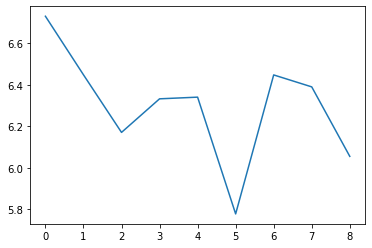

In [93]:
plt.plot(epochs,diversities)